## Install dependencies

In [2]:
import numpy as np
from scipy.linalg import solve_discrete_are
import pypoman

In [11]:
import sys
sys.path
import reach_lp
from importlib import reload

In [4]:
from reach_lp.mpc import control_mpc, control_linear
from reach_lp.sim import run_simulation
from reach_lp.nn import load_model, control_nn
from reach_lp.lp import reachLP_1, reachLP_n, init_state_range_to_polytope
from reach_lp.reach_sdp import reachSDP_n

Using TensorFlow backend.


## Dynamics

In [5]:
# Dynamics
# Double integrator
At = np.array([[1, 1],[0, 1]])
bt = np.array([[0.5], [1]])
ct = np.array([0., 0.]).T
num_states, num_inputs = bt.shape

init_state_range = np.array([
                      [2.5, 3.0],
                      [-0.25, 0.25]
])
goal_state_range = np.array([
                      [-0.25, 0.25],
                      [-0.25, 0.25]            
])

# Sampling & simulation time
dt = 1.0
t_max = 6

Q = np.eye(2)
R = 1
Pinf = solve_discrete_are(At, bt, Q, R)

# u_min = -5; u_max = 5
u_min = -1; u_max = 1

In [15]:
from reach_lp.nn import load_model
model = load_model()
def get_polytope_A(num):
    theta = np.linspace(0,2*np.pi,num=num)
    A_out = np.dstack([np.cos(theta), np.sin(theta)])[0][:-1]
    return A_out
def get_next_state(xt, ut, At, bt, ct):
    return np.dot(At, xt.T) + np.dot(bt,ut.T)

Loaded model from disk


Loaded model from disk


100%|██████████| 1000/1000 [00:01<00:00, 632.02it/s]


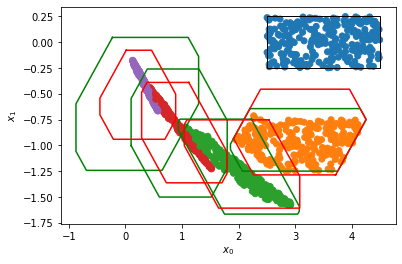

In [25]:
import reach_lp
reload(reach_lp.lp)
from reach_lp.lp import reachLP_1, reachLP_n, init_state_range_to_polytope
reload(reach_lp.nn)
reload(reach_lp.nn_bounds)
reload(reach_lp.sim)
from reach_lp.nn import load_model
from reach_lp.sim import run_simulation
reload(reach_lp.reach_sdp)
from reach_lp.reach_sdp import reachSDP_n

init_state_range = np.array([
                      [2.5, 4.5],
                      [-0.25, 0.25]
    ])
A_inputs, b_inputs = init_state_range_to_polytope(init_state_range)

all_A_out = []
all_all_bs = []


    
all_A_out.append(get_polytope_A(9))
# all_A_out.append(get_polytope_A(9))
# all_A_out.append(get_polytope_A(5))

t_max = 4
for A_out in all_A_out:
    all_bs = reachLP_n(t_max, model, A_inputs, b_inputs, At, bt, ct, A_out, u_limits=[u_min, u_max])
    all_all_bs.append(all_bs)

# all_A_out.append(all_A_out[0])
# all_bs = reachLP_n(t_max, model, A_inputs, b_inputs, At, bt, ct, A_out)
# all_all_bs.append(all_bs)

# SDP (pre-solved)
sdp_output_polytope_A = get_polytope_A(9)
all_bs = reachSDP_n(t_max, model, A_inputs, b_inputs, At, bt, ct, sdp_output_polytope_A, u_min=u_min, u_max=u_max)
# sdp_all_bs_small = all_bs.copy()
sdp_all_bs_large = all_bs.copy()
# sdp_all_bs_small_unbounded = all_bs.copy()
# sdp_all_bs_large_unbounded = all_bs.copy()

sdp_all_bs = sdp_all_bs_large
# sdp_all_bs = sdp_all_bs_small
# sdp_all_bs = sdp_all_bs_small_unbounded
# sdp_all_bs = sdp_all_bs_large_unbounded

all_A_out.append(sdp_output_polytope_A)
all_all_bs.append(sdp_all_bs)

run_simulation(At, bt, ct, dt,
           t_max, init_state_range, goal_state_range,
           u_min, u_max, num_states,
           collect_data=False,
           show_bounds=True, all_bs=all_all_bs, A_in=all_A_out, bnd_colors=['g','r','c','r'],
           model=model,
           save_plot=False,
        num_samples = 1000, clip_control=True, show_dataset=False)

Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


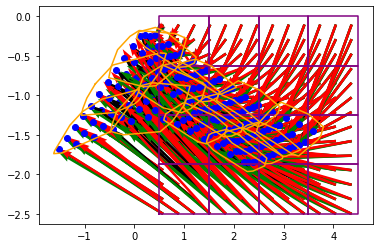

In [187]:
import matplotlib.pyplot as plt
reload(reach_lp.nn)
reload(reach_lp.nn_bounds)
from reach_lp.nn import load_model, control_nn
reload(reach_lp.reach_lp)
from reach_lp.reach_lp import min_and_max_controls

fig, ax = plt.subplots()

# print(all_all_bs[0][0])
# all_all_bs[0]

X = np.linspace(-1, 5, num=20)
Y = np.linspace(-2.5, 1.0, num=20)
U, V = np.meshgrid(X, Y)

def get_next_state(xt, ut, At, bt, ct):
    return np.dot(At, xt.T) + np.dot(bt,ut.T)

init_state_range = np.array([
                      [0.5, 4.5],
                      [-2.5, 0.0]
    ])
A_inputs, b_inputs = init_state_range_to_polytope(init_state_range)

num_x0 = 4; num_x1 = 4
for i in range(num_x0):
    for j in range(num_x1):
        x0_slope = (init_state_range[0][1] - init_state_range[0][0])/num_x0
        x1_slope = (init_state_range[1][1] - init_state_range[1][0])/num_x1
        init_state_range_ = np.array([[init_state_range[0][0]+x0_slope*i, init_state_range[0][0]+x0_slope*(i+1)],
                                    [init_state_range[1][0]+x1_slope*j, init_state_range[1][0]+x1_slope*(j+1)]])
        A_inputs, b_inputs = init_state_range_to_polytope(init_state_range_)
        
        A_to_start = A_inputs
        b_to_start = b_inputs
        A_to_end = get_polytope_A(30)
        # A_to_start = all_A_out[0]
        # b_to_start = all_all_bs[0][0]
        # A_to_end = all_A_out[0]
        # b_to_end = all_all_bs[0][1]

        t_max = 1
        b_to_end = reachLP_n(t_max, model, A_to_start, b_to_start, At, bt, ct, A_to_end)[0]

        pts = np.reshape(np.dstack([U, V]), (-1,2))
        tmp = np.all(np.dot(A_to_start, pts.T).T <= b_to_start, axis=1)
        pts = pts[tmp]

        us = control_nn(pts)

        # pi_l, pi_u = min_and_max_controls(pts, all_A_out[0], all_all_bs[0][0], At, bt, ct, None)
        pi_l, pi_u = min_and_max_controls(pts, A_to_start, b_to_start, At, bt, ct, None)

        # print(np.hstack([pi_l, us, pi_u]))

        next_states = get_next_state(pts, us, At, bt, ct)
        next_states_l = get_next_state(pts, pi_l, At, bt, ct)
        next_states_u = get_next_state(pts, pi_u, At, bt, ct)
        delta_state = next_states - pts.T
        delta_state_l = next_states_l - pts.T
        delta_state_u = next_states_u - pts.T

        q = ax.quiver(pts[:,0], pts[:,1], delta_state[0,:], delta_state[1,:], angles='xy', scale_units='xy', scale=1.)
        q = ax.quiver(pts[:,0], pts[:,1], delta_state_l[0,:], delta_state_l[1,:], angles='xy', scale_units='xy', scale=1., color='green')
        q = ax.quiver(pts[:,0], pts[:,1], delta_state_u[0,:], delta_state_u[1,:], angles='xy', scale_units='xy', scale=1., color='red')

        vertices = pypoman.compute_polygon_hull(A_to_start, b_to_start)
        bnd_color = 'purple'
        plt.plot([v[0] for v in vertices]+[vertices[0][0]], [v[1] for v in vertices]+[vertices[0][1]], bnd_color)

        vertices = pypoman.compute_polygon_hull(A_to_end, b_to_end)
        bnd_color = 'orange'
        plt.plot([v[0] for v in vertices]+[vertices[0][0]], [v[1] for v in vertices]+[vertices[0][1]], bnd_color)

        plt.scatter(next_states[0,:], next_states[1,:], color='blue')

plt.show()

In [157]:
pi_l

array([[-0.64],
       [-0.75],
       [-0.86],
       [-0.74],
       [-0.84],
       [-0.95],
       [-0.72],
       [-0.83],
       [-0.93],
       [-1.04],
       [-0.92],
       [-1.03]])

## Run reach sdp on a few network sizes


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

100%|██████████| 100/100 [00:00<00:00, 310.23it/s]


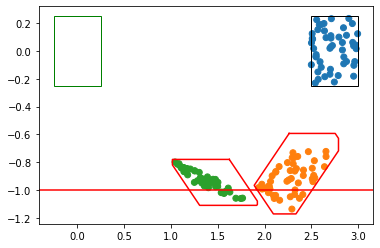


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]

100%|██████████| 8/8 [00:10<00:00,  1.33s/it]

100%|██████████| 100/100 [00:00<00:00, 318.38it/s]


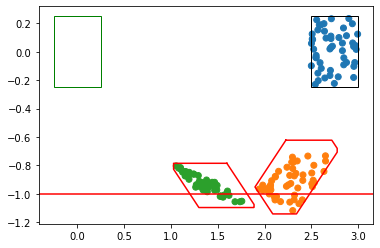


100%|██████████| 8/8 [00:17<00:00,  2.18s/it]

100%|██████████| 8/8 [00:18<00:00,  2.32s/it]

100%|██████████| 100/100 [00:00<00:00, 312.55it/s]


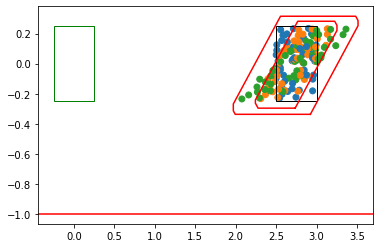


100%|██████████| 8/8 [00:19<00:00,  2.50s/it]

100%|██████████| 8/8 [00:18<00:00,  2.30s/it]

100%|██████████| 100/100 [00:00<00:00, 349.78it/s]


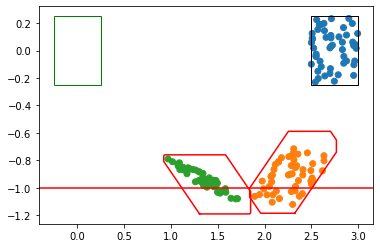


100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

100%|██████████| 100/100 [00:00<00:00, 341.49it/s]


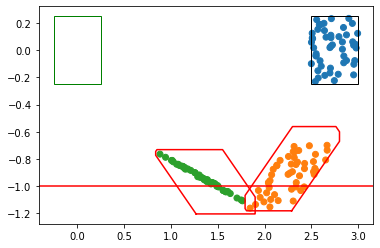

In [39]:
all_neurons_per_layer = [
  [10,5],
#   # [8,5],
#   # [6,5],
#   # [4,5],
#   # [2,5],
#   [2,2],
#   [2,4],
#   [2,6],
#   [2,8],
#   [2,5],
]

t_max = 2

for neurons_per_layer in all_neurons_per_layer:
  plot_name = '_'.join(str(x).zfill(3) for x in neurons_per_layer)+'_reach_sdp_'+str(t_max)+'.png'
  model = create_and_train_model(neurons_per_layer, xs, us)
  all_bs = reachSDP_n(t_max, model, A_inputs, b_inputs, At, bt, ct, A_in)

  run_simulation(At, bt, ct,
               t_max, init_state_range, goal_state_range,
               u_min, u_max, num_states,
               collect_data=False,
               show_bounds=True, all_bs=all_bs, A_in=A_in,
               model=model,
               save_plot=True,
               plot_name=plot_name)


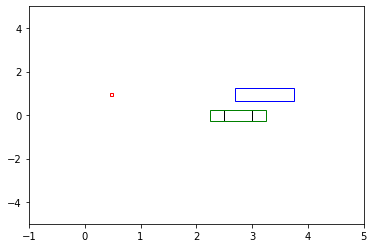

In [57]:
At_xt_max = np.empty((num_states,))
At_xt_min = np.empty((num_states,))
bt_ut_max = np.empty((num_states,))
bt_ut_min = np.empty((num_states,))
xt1_max = np.empty((num_states,))
xt1_min = np.empty((num_states,))

u_min_ = 0.9
u_max_ = 1.0

for state in range(num_states):
  At_xt_max[state] = np.max(At[state,0]*init_state_range[0,:]) + np.max(At[state,1]*init_state_range[1,:])
  At_xt_min[state] = np.min(At[state,0]*init_state_range[0,:]) + np.min(At[state,1]*init_state_range[1,:])

  bt_ut_max[state] = np.max(bt[state]*np.array([u_min_, u_max_]))
  bt_ut_min[state] = np.min(bt[state]*np.array([u_min_, u_max_]))

  xt1_max[state] = At_xt_max[state]+bt_ut_max[state]
  xt1_min[state] = At_xt_min[state]+bt_ut_min[state]

# Input state rectangle
rect = ptch.Rectangle(init_state_range[:,0],
                      init_state_range[0,1]-init_state_range[0,0], 
                      init_state_range[1,1]-init_state_range[1,0],
                      fill=False, ec='k')
plt.gca().add_patch(rect)

# Goal state rectangle
rect = ptch.Rectangle(At_xt_min,
                      At_xt_max[0]-At_xt_min[0],
                      At_xt_max[1]-At_xt_min[1],
                      fill=False, ec='green')
plt.gca().add_patch(rect)

rect = ptch.Rectangle(bt_ut_min,
                      bt_ut_max[0]-bt_ut_min[0],
                      bt_ut_max[1]-bt_ut_min[1],
                      fill=False, ec='red')
plt.gca().add_patch(rect)

rect = ptch.Rectangle(xt1_min,
                      xt1_max[0]-xt1_min[0],
                      xt1_max[1]-xt1_min[1],
                      fill=False, ec='blue')
plt.gca().add_patch(rect)

plt.gca().set_xlim([-1,5])
plt.gca().set_ylim([-5,5])

plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 264.85it/s]


TypeError: 'numpy.bool_' object is not iterable

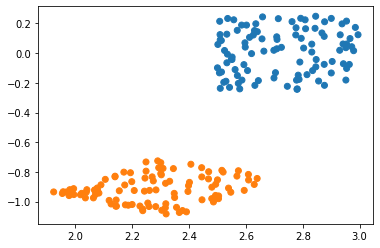

In [31]:
t_max = 1
neurons_per_layer = [10,5]
plot_name = '_'.join(str(x).zfill(3) for x in neurons_per_layer)+'_reach_sdp_'+str(t_max)+'.png'
# model = create_and_train_model(neurons_per_layer, xs, us)
all_bs = reachSDP_n(t_max, model, A_inputs, b_inputs, At, bt, ct, A_in, u_min, u_max)

run_simulation(At, bt, ct,
           t_max, init_state_range, goal_state_range,
           u_min, u_max, num_states,
           collect_data=False,
           show_bounds=True, all_bs=all_bs, A_in=A_in,
           model=model,
           save_plot=True,
           plot_name=plot_name)

## Extras

In [0]:
# Generate a random SDP.
n = 3
p = 3
np.random.seed(1)
C = np.random.randn(n, n)
A = []
b = []
for i in range(p):
    A.append(np.random.randn(n, n))
    b.append(np.random.randn())

# Define and solve the CVXPY problem.
# Create a symmetric matrix variable.
X = cp.Variable((n,n), symmetric=True)
# The operator >> denotes matrix inequality.
constraints = [X >> 0]
# constraints = []
constraints += [
    mat_constr(i=0,j=0,val=1.,mat=X),
    mat_constr(i=0,j=1,val=2.,mat=X),
    mat_constr(i=0,j=2,val=3.,mat=X),
    mat_constr(i=1,j=1,val=4.,mat=X),
    # mat_constr(i=1,j=2,val=5.,mat=X),
    # mat_constr(i=2,j=2,val=6.,mat=X),
    # cp.trace(A[i] @ X) == b[i] for i in range(p)
]

# A__ = np.zeros((n,n))
# A__[0,0] = 1
# b__ = 5

# print(cp.trace(A__ @ X))

# constraints.append(cp.trace(A__ @ X) == b__)
# prob = cp.Problem(cp.Minimize(cp.trace(X)),
prob = cp.Problem(cp.Minimize(X[1,2]),
                  constraints)
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)
print(np.linalg.eig(X.value)[0])

The optimal value is -25.890119296848887
A solution X is
[[ 1.0e+00  2.0e+00  3.0e+00]
 [ 2.0e+00  4.0e+00 -2.6e+01]
 [ 3.0e+00 -2.6e+01  2.9e+09]]
[ 2.9e+09 -2.8e-03  5.0e+00]


In [0]:
P = cp.Variable((num_states+1, num_states+1), symmetric=True)
Gamma = cp.Variable((m,m), symmetric=True)
Gamma2 = cp.Variable((m,m), nonneg=True)

input_set_constrs = []

for i,j in itertools.combinations_with_replacement(range(m),2):
  input_set_constrs += [
    # Ensure each term in Gamma >= 0
    mat_constr(i=i,j=j,val=Gamma2[i,j],mat=Gamma)
  ]

input_set_constrs += [
  mat_constr(i=0,j=0,val=cp.quad_form(A_inputs, Gamma)[0,0],mat=P),
  mat_constr(i=0,j=1,val=cp.quad_form(A_inputs, Gamma)[0,1],mat=P),
  mat_constr(i=1,j=1,val=cp.quad_form(A_inputs, Gamma)[1,1],mat=P),
  mat_constr(i=0,j=2,val=(-A_inputs.T*Gamma*b_inputs)[0],mat=P),
  mat_constr(i=1,j=2,val=(-A_inputs.T*Gamma*b_inputs)[1],mat=P),
  mat_constr(i=2,j=2,val=cp.quad_form(b_inputs, Gamma),mat=P),
  # mat_constr(i=2,j=2,val=
  #            cp.quad_form(np.array([0.5, 0.6, 0.8, 0.9]),Gamma),
  #           mat=P),
  ]

prob = cp.Problem(cp.Minimize(cp.trace(P)),
                  input_set_constrs)
print(prob.solve())
print(prob.status)
print(Gamma.value)

-inf
unbounded
None


In [0]:
nn_constrs = []

# Set up T
# d = num_neurons+2*num_inputs
d = 4
T = cp.Variable((d,d), PSD=True)
lamb_ij = cp.Variable((d,d), nonneg=True)
lamb_i = cp.Variable((d))
pairs = list(itertools.combinations(range(d), 2))

for i in range(d):
  if i == 0:
    first = 0
  else:
    # first = '+'.join(['l_ij['+str(j)+','+str(i)+']' for j in range(0,i)])
    first = cp.sum(lamb_ij[:i,i])
  if i == d-1:
    second = 0
  else:
    # second = '+'.join(['l_ij['+str(i)+','+str(j)+']' for j in range(i+1,d)])
    second = cp.sum(lamb_ij[i, i+1:])
  val = first+second+lamb_i[i]
  # val = cp.sum(lamb_ij[i,:])-lamb_ij[i,i]+lamb_i[i]
  nn_constrs += [mat_constr(i=i,j=i,val=val,mat=T)]

for i,j in pairs:
  val = -lamb_ij[i,j]
  nn_constrs += [mat_constr(i=i,j=j,val=val,mat=T)]

prob = cp.Problem(cp.Minimize(cp.trace(T)),
                  nn_constrs)
print(prob.solve())
print(prob.status)
print(T.value)

0 1
0 2
0 3
1 2
1 3
2 3
3.487714783831201e-13
optimal
[[8.7e-14 6.1e-15 6.1e-15 6.1e-15]
 [6.1e-15 8.7e-14 6.1e-15 6.1e-15]
 [6.1e-15 6.1e-15 8.7e-14 6.1e-15]
 [6.1e-15 6.1e-15 6.1e-15 8.7e-14]]


In [0]:
d = 4
T = np.empty((d,d), dtype=object)
pairs = list(itertools.combinations(range(d), 2))

for (i,j) in itertools.product(range(d),repeat=2):
  T[i,j] = ''

for i in range(d):
  if i == 0:
    first = ''
  else:
    first = '+'.join(['l_ij['+str(j)+','+str(i)+']' for j in range(0,i)])
  if i == d-1:
    second = ''
  else:
    second = '+'.join(['l_ij['+str(i)+','+str(j)+']' for j in range(i+1,d)])
  T[i,i] += 'l_'+str(i)+'+'+first+second

for i,j in pairs:
  T[i,j] += '-l_ij['+str(i)+','+str(j)+']'
  # val = -lamb_ij[i,j]

print(T)



[['l_0+l_ij[0,1]+l_ij[0,2]+l_ij[0,3]' '-l_ij[0,1]' '-l_ij[0,2]'
  '-l_ij[0,3]']
 ['' 'l_1+l_ij[0,1]l_ij[1,2]+l_ij[1,3]' '-l_ij[1,2]' '-l_ij[1,3]']
 ['' '' 'l_2+l_ij[0,2]+l_ij[1,2]l_ij[2,3]' '-l_ij[2,3]']
 ['' '' '' 'l_3+l_ij[0,3]+l_ij[1,3]+l_ij[2,3]']]


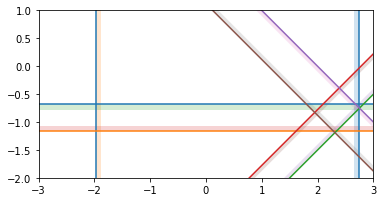

In [0]:
def plot(A, b):
  fill=0.1
  alpha=0.2
  xlim = [-3,3]
  ylim = [-2,1]
  num_planes = A.shape[0]
  for i in range(num_planes):
    if A[i,1] == 0:
      plt.axvline(x=b[i])
      if A[i,0] > 0:
        fill_ = -fill
      else:
        fill_ = fill
      plt.fill_betweenx(ylim,b[i],x2=b[i]+fill_,alpha=alpha)
    else:
      x0 = np.linspace(-5.,5.,num=2)
      x1 = (b[i]-x0*A[i,0])/A[i,1]
      plt.plot(x0, x1)
      if A[i,1] > 0:
        fill_ = -fill
      else:
        fill_ = fill
      plt.fill_between(x0,x1,x1+fill_,alpha=alpha)
  plt.gca().set_xlim(xlim)
  plt.gca().set_ylim(ylim)
  plt.gca().set_aspect('equal')
  plt.show()

plot(A_in,bs)

Loaded model from disk


TypeError: min_and_max_controls() takes from 4 to 5 positional arguments but 7 were given

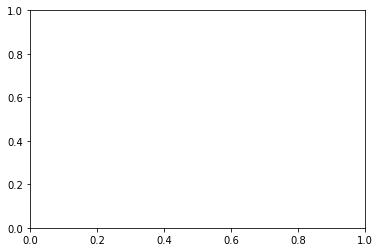

In [32]:
import matplotlib.pyplot as plt
from importlib import reload
reload(reach_lp.nn)
reload(reach_lp.nn_bounds)
from reach_lp.nn import load_model, control_nn
reload(reach_lp.lp)
from reach_lp.lp import min_and_max_controls

def reachable_set_partitioned(init_state_range, num_x0, num_x1, A_inputs, b_inputs, model, At, bt, ct):
    fig, ax = plt.subplots()
    
    X = np.linspace(init_state_range[0][0], init_state_range[0][1], num=10)
    Y = np.linspace(init_state_range[1][0], init_state_range[1][1], num=10)
    U, V = np.meshgrid(X, Y)

    for i in range(num_x0):
        for j in range(num_x1):
            x0_slope = (init_state_range[0][1] - init_state_range[0][0])/num_x0
            x1_slope = (init_state_range[1][1] - init_state_range[1][0])/num_x1
            init_state_range_ = np.array([[init_state_range[0][0]+x0_slope*i, init_state_range[0][0]+x0_slope*(i+1)],
                                        [init_state_range[1][0]+x1_slope*j, init_state_range[1][0]+x1_slope*(j+1)]])
            A_inputs, b_inputs = init_state_range_to_polytope(init_state_range_)

            A_to_start = A_inputs
            b_to_start = b_inputs
            A_to_end = get_polytope_A(30)
            # A_to_start = all_A_out[0]
            # b_to_start = all_all_bs[0][0]
            # A_to_end = all_A_out[0]
            # b_to_end = all_all_bs[0][1]

            t_max = 1
            b_to_end = reachLP_n(t_max, model, A_to_start, b_to_start, At, bt, ct, A_to_end)[0]

            pts = np.reshape(np.dstack([U, V]), (-1,2))
            tmp = np.all(np.dot(A_to_start, pts.T).T <= b_to_start, axis=1)
            pts = pts[tmp]

            us = control_nn(pts)

            # pi_l, pi_u = min_and_max_controls(pts, all_A_out[0], all_all_bs[0][0], At, bt, ct, None)
            pi_l, pi_u = min_and_max_controls(pts, A_to_start, b_to_start, At, bt, ct, None)

            # print(np.hstack([pi_l, us, pi_u]))

            next_states = get_next_state(pts, us, At, bt, ct)
            next_states_l = get_next_state(pts, pi_l, At, bt, ct)
            next_states_u = get_next_state(pts, pi_u, At, bt, ct)
            delta_state = next_states - pts.T
            delta_state_l = next_states_l - pts.T
            delta_state_u = next_states_u - pts.T

            q = ax.quiver(pts[:,0], pts[:,1], delta_state[0,:], delta_state[1,:], angles='xy', scale_units='xy', scale=1.)
            q = ax.quiver(pts[:,0], pts[:,1], delta_state_l[0,:], delta_state_l[1,:], angles='xy', scale_units='xy', scale=1., color='green')
            q = ax.quiver(pts[:,0], pts[:,1], delta_state_u[0,:], delta_state_u[1,:], angles='xy', scale_units='xy', scale=1., color='red')

            vertices = pypoman.compute_polygon_hull(A_to_start, b_to_start)
            bnd_color = 'purple'
            plt.plot([v[0] for v in vertices]+[vertices[0][0]], [v[1] for v in vertices]+[vertices[0][1]], bnd_color)

            vertices = pypoman.compute_polygon_hull(A_to_end, b_to_end)
            bnd_color = 'orange'
            plt.plot([v[0] for v in vertices]+[vertices[0][0]], [v[1] for v in vertices]+[vertices[0][1]], bnd_color)

            plt.scatter(next_states[0,:], next_states[1,:], color='blue')

    plt.show()

init_state_range = np.array([
                      [0.5, 4.5],
                      [-2.5, 0.0]
    ])
A_inputs, b_inputs = init_state_range_to_polytope(init_state_range)

num_x0 = 1; num_x1 = 1
reachable_set_partitioned(init_state_range, num_x0, num_x1, A_inputs, b_inputs, model, At, bt, ct)
num_x0 = 2; num_x1 = 1
reachable_set_partitioned(init_state_range, num_x0, num_x1, A_inputs, b_inputs, model, At, bt, ct)
num_x0 = 1; num_x1 = 2
reachable_set_partitioned(init_state_range, num_x0, num_x1, A_inputs, b_inputs, model, At, bt, ct)

In [329]:
from crown_ibp.conversions.keras2torch import keras2torch, get_keras_model
reload(reach_lp.nn_bounds)
import crown_ibp
reload(crown_ibp.bound_layers)
from reach_lp.nn_bounds import BoundSequential
import torch

def nn_reachable_set_partitioned(init_state_range, num_x0, num_x1, model, method='crown', viz=False):

    if viz:
        fig, axes = plt.subplots(1,2)

        num = 10
        X = np.linspace(init_state_range[0][0], init_state_range[0][1], num=num)
        Y = np.linspace(init_state_range[1][0], init_state_range[1][1], num=num)
        U, V = np.meshgrid(X, Y)
    
    u_min = np.inf
    u_max = -np.inf
    pi_min = np.inf
    pi_max = -np.inf

    for i in range(num_x0):
        for j in range(num_x1):
            x0_slope = (init_state_range[0][1] - init_state_range[0][0])/num_x0
            x1_slope = (init_state_range[1][1] - init_state_range[1][0])/num_x1
            init_state_range_ = np.array([[init_state_range[0][0]+x0_slope*i, init_state_range[0][0]+x0_slope*(i+1)],
                                        [init_state_range[1][0]+x1_slope*j, init_state_range[1][0]+x1_slope*(j+1)]])
            
            # Get over-approximated bounds across input set
            if method == 'crown':
                ub, lb = model.full_backward_range(norm=np.inf,
                                            x_U=torch.Tensor([init_state_range_[:,1]]),
                                            x_L=torch.Tensor([init_state_range_[:,0]]),
                                            upper=True, lower=True, C=torch.Tensor([[[1]]]))[:2]
            elif method == 'ibp':
                ub, lb = model.interval_range(norm=np.inf,
                                            x_U=torch.Tensor([init_state_range_[:,1]]),
                                            x_L=torch.Tensor([init_state_range_[:,0]]),
                                            eps=None, C=torch.Tensor([[[1]]]))[:2]
            else:
                print("Method ({}) not implemented".format(method))
                return
            pi_min = min(lb, pi_min)
            pi_max = max(ub, pi_max)
            
            if viz:
                # Get the CROWN matrices (just so we can compute sampled pts' correspondants)
                lower_A, upper_A, lower_sum_b, upper_sum_b = model.full_backward_range(norm=np.inf,
                                            x_U=torch.Tensor([init_state_range_[:,1]]),
                                            x_L=torch.Tensor([init_state_range_[:,0]]),
                                            upper=True, lower=True, C=torch.Tensor([[[1]]]),
                                            return_matrices=True)
                
                A_inputs, b_inputs = init_state_range_to_polytope(init_state_range_)
                A_to_start = A_inputs
                b_to_start = b_inputs

                pts = np.reshape(np.dstack([U, V]), (-1,2))
                tmp = np.all(np.dot(A_to_start, pts.T).T <= b_to_start, axis=1)
                pts = pts[tmp]

                us = control_nn(pts)
                u_min = min(np.min(us), u_min)
                u_max = max(np.max(us), u_max)

                omega = lower_A.data.numpy()
                lamb = upper_A.data.numpy()
                nl = lower_sum_b.data.numpy().squeeze()
                ul = upper_sum_b.data.numpy().squeeze()
                pi_l = np.dot(omega, pts.T).squeeze()+nl
                pi_u = np.dot(lamb, pts.T).squeeze()+ul
                pi_l = np.expand_dims(pi_l, axis=-1)
                pi_u = np.expand_dims(pi_u, axis=-1)
            
                x = i*num_x1 + j
                sep = 0.3

                ax = axes[1]
                q = ax.quiver(np.ones_like(us[:,0])*x, us[:,0], np.ones_like(us[:,0])*-sep, (pi_l-us)[:,0], angles='xy', scale_units='xy', scale=1.)
                q = ax.quiver(np.ones_like(us[:,0])*x, us[:,0], np.ones_like(us[:,0])*sep, (pi_u-us)[:,0], angles='xy', scale_units='xy', scale=1.)

                ax.scatter(np.ones_like(us)*x, us)
                ax.scatter(np.ones_like(us)*x+sep, pi_u)
                ax.scatter(np.ones_like(us)*x-sep, pi_l)

                ax = axes[0]
                vertices = pypoman.compute_polygon_hull(A_to_start, b_to_start)
                bnd_color = 'purple'
                ax.plot([v[0] for v in vertices]+[vertices[0][0]], [v[1] for v in vertices]+[vertices[0][1]], bnd_color)

    if viz:
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['bottom'].set_visible(False)
        axes[1].get_xaxis().set_visible(False)

        ax = axes[1]
        ax.axhline(u_min, ls='--')
        ax.axhline(u_max, ls='--')
        ax.axhline(pi_min, ls='--')
        ax.axhline(pi_max, ls='--')
        plt.show()
    
    return pi_min.data.numpy(), pi_max.data.numpy()

Loaded model from disk


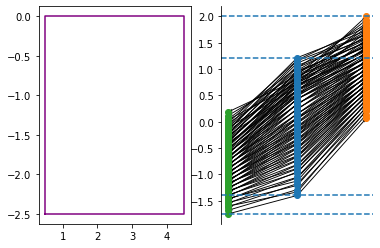

Loaded model from disk
Loaded model from disk


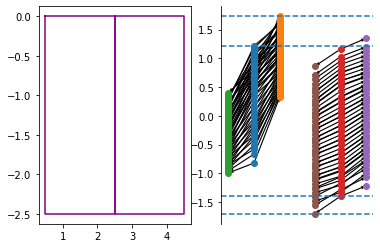

(array([[-1.57]], dtype=float32), array([[1.42]], dtype=float32))

In [324]:
torch_model = keras2torch(model, "torch_model")
torch_model_ = BoundSequential.convert(torch_model, {"same-slope": True})

init_state_range = np.array([
                      [0.5, 4.5], # x0min, x0max
                      [-2.5, 0.0] # x1min, x1max
    ])
A_inputs, b_inputs = init_state_range_to_polytope(init_state_range)

num_x0 = 1; num_x1 = 1
nn_reachable_set_partitioned(init_state_range, num_x0, num_x1, torch_model_, viz=True)

num_x0 = 2; num_x1 = 1
nn_reachable_set_partitioned(init_state_range, num_x0, num_x1, torch_model_, viz=True)

num_x0 = 2; num_x1 = 2
nn_reachable_set_partitioned(init_state_range, num_x0, num_x1, torch_model_, viz=False)

In [327]:
def get_sampled_bounds(nominal_state=None, epsilon=None, init_state_range=None, num=10):
    # This works for a 2D input, 1D output only.
    # Provide EITHER init_state_range OR nominal_state & eps
    if nominal_state is not None and epsilon is not None:
        init_state_range = get_init_state_range(nominal_state, epsilon)
    
    X = np.linspace(init_state_range[0][0], init_state_range[0][1], num=num)
    Y = np.linspace(init_state_range[1][0], init_state_range[1][1], num=num)
    U, V = np.meshgrid(X, Y)
    pts = np.reshape(np.dstack([U, V]), (-1,2))

    us = control_nn(pts)
    u_min = np.min(us)
    u_max = np.max(us)
    
    return u_min, u_max

u_min, u_max = get_sampled_bounds(init_state_range=init_state_range)

[[ 0.5  4.5]
 [-2.5  0. ]]
Loaded model from disk


In [384]:
import time
torch_model = keras2torch(model, "torch_model")
torch_model_ = BoundSequential.convert(torch_model, {"same-slope": True})

def get_init_state_range(nominal_state, epsilon):
    states = np.tile(nominal_state, (2,1)).T
    states[:,0] -= epsilon
    states[:,1] += epsilon
    return states

def get_bounds(nominal_state, epsilon, model, method='crown', num_repeats_for_computation_time=1):
    init_state_range = get_init_state_range(nominal_state, epsilon)
    # init_state_range = np.array([
    #                       [0.5, 4.5], # x0min, x0max
    #                       [-2.5, 0.0] # x1min, x1max
    #     ])

    # Compute successively tighter approximations
    num_x0 = 0.5; num_x1 = 1;
    num = 10
    bounds = []
    bounds = np.empty((num, 4))
    for num in range(num):
        if num % 2 == 0: num_x0 = int(num_x0*2)
        else: num_x1 = int(num_x1*2)
        
        t_start = time.time()
        for _ in range(num_repeats_for_computation_time):
            pi_min, pi_max = nn_reachable_set_partitioned(init_state_range, num_x0, num_x1, model, method=method)
        t_end = time.time()
        bounds[num] = [num, pi_min, pi_max, (t_end - t_start)/num_repeats_for_computation_time]

    # Compute exact bounds (via sampling)
    return bounds

### For a single value of epsilons
nominal_state = [0., -1.]
epsilons = 10.0
crown_bounds = get_bounds(nominal_state, epsilon, torch_model_, method='crown')
ibp_bounds = get_bounds(nominal_state, epsilon, torch_model_, method='ibp')
u_min, u_max = get_sampled_bounds(nominal_state=nominal_state, epsilon=epsilon)

### For a range of epsilon values
# nominal_state = [2., -1.]
# epsilons = np.linspace(0, 10, 5)
# results = {}
# for epsilon in epsilons:
#     print(epsilon)
#     crown_bounds = get_bounds(nominal_state, epsilon, torch_model_, method='crown', num_repeats_for_computation_time=5)
#     ibp_bounds = get_bounds(nominal_state, epsilon, torch_model_, method='ibp', num_repeats_for_computation_time=5)
#     u_min, u_max = get_sampled_bounds(nominal_state=nominal_state, epsilon=epsilon)
    
#     results[epsilon] = {}
#     results[epsilon]['crown'] = crown_bounds
#     results[epsilon]['ibp'] = ibp_bounds
#     results[epsilon]['exact'] = [u_min, u_max]  

/Users/mfe/code/gym-collision-avoidance/venv/lib/python3.7/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Loaded model from disk


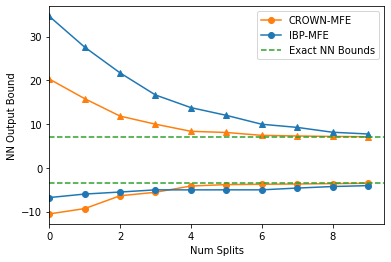

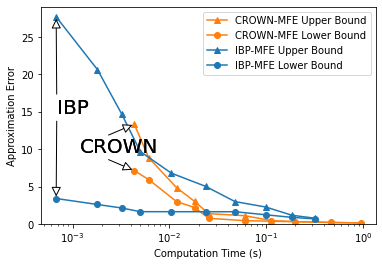

In [385]:
algs = {
    'ibp_mfe': {
        'color': plt.get_cmap('tab10')(0)
    },
    'crown_mfe': {
        'color': plt.get_cmap('tab10')(1)
    },
    'exact': {
        'color': plt.get_cmap('tab10')(2)
    }
}

# Plot
def plot_num_splits_vs_approx_error(crown_bounds, ibp_bounds, u_min, u_max, ax=None, show=True):
    if ax is None:
        fig, ax = plt.subplots()
#     ax.axhline(crown_bounds[0,1],ls='--', c='red',label="CROWN")
#     ax.axhline(crown_bounds[0,2],ls='--', c='red')
#     ax.axhline(ibp_bounds[0,1],ls='--', c='magenta',label="IBP")
#     ax.axhline(ibp_bounds[0,2],ls='--', c='magenta')
    ax.plot(crown_bounds[:,0], crown_bounds[:,1], c=algs['crown_mfe']['color'], marker="o", label="CROWN-MFE")
    ax.plot(crown_bounds[:,0], crown_bounds[:,2], c=algs['crown_mfe']['color'], marker="^")
    ax.plot(ibp_bounds[:,0], ibp_bounds[:,1], c=algs['ibp_mfe']['color'], marker="o", label="IBP-MFE")
    ax.plot(ibp_bounds[:,0], ibp_bounds[:,2], c=algs['ibp_mfe']['color'], marker="^")
    ax.axhline(u_min,ls='--', c=algs['exact']['color'],label="Exact NN Bounds")
    ax.axhline(u_max,ls='--', c=algs['exact']['color'])
    ax.set_xlabel('Num Splits')
#     ax.set_ylabel('NN Output Bound', rotation=0, labelpad=50)
    ax.set_ylabel('NN Output Bound')
    ax.set_xlim(left=0)
    ax.legend()
    if show:
        plt.savefig('/Users/mfe/dnn_reachability_paper/figures/num_splits_vs_bound.png')
        plt.savefig('/Users/mfe/dnn_reachability_paper/figures/num_splits_vs_bound.pdf')
        plt.show()

def plot_comp_time_vs_num_splits(bounds, ax=None, show=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(bounds[:,0], bounds[:,3])
    ax.ylabel('Computation Time (s)')
    ax.xlabel('Num Splits')
    if show:
        plt.show()

def plot_comp_time_vs_approx_error(crown_bounds, ibp_bounds, u_min, u_max, ax=None, show=True, color=None, label='', annotate=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.semilogx(crown_bounds[:,3], crown_bounds[:,2]-u_max, ls='-', marker='^', color=algs['crown_mfe']['color'], label="CROWN-MFE Upper Bound"+label)
    ax.semilogx(crown_bounds[:,3], u_min-crown_bounds[:,1], ls='-', marker='o', color=algs['crown_mfe']['color'], label="CROWN-MFE Lower Bound"+label)
    ax.semilogx(ibp_bounds[:,3], ibp_bounds[:,2]-u_max, ls='-', marker='^', color=algs['ibp_mfe']['color'], label="IBP-MFE Upper Bound"+label)
    ax.semilogx(ibp_bounds[:,3], u_min-ibp_bounds[:,1], ls='-', marker='o', color=algs['ibp_mfe']['color'], label="IBP-MFE Lower Bound"+label)
    ax.set_xlabel("Computation Time (s)")
#     ax.set_ylabel("Approximation Error", rotation=0, labelpad=50)
    ax.set_ylabel("Approximation Error")
    ax.set_ylim(bottom=0)
    ax.legend()
    
    if annotate:
        ann = ax.annotate("CROWN",
                      xy=(crown_bounds[0,3], crown_bounds[0,2]-u_max), xycoords='data',
                      xytext=(0.003, ((crown_bounds[0,2]-u_max)+(u_min-crown_bounds[0,1]))/2.), textcoords='data',
                      size=20, va="center", ha="center",
                      arrowprops=dict(arrowstyle="-|>",
                                      connectionstyle="arc3",
                                      relpos=(0., 0.5),
                                      fc="w"),
                      )

        ann = ax.annotate("CROWN",
                          xy=(crown_bounds[0,3], u_min-crown_bounds[0,1]), xycoords='data',
                          xytext=(0.003, ((crown_bounds[0,2]-u_max)+(u_min-crown_bounds[0,1]))/2.), textcoords='data',
                          size=20, va="center", ha="center",
                          arrowprops=dict(arrowstyle="-|>",
                                          connectionstyle="arc3",
                                          relpos=(0., 0.5),
                                          fc="w"),
                          )
        ann = ax.annotate("IBP",
                      xy=(ibp_bounds[0,3], ibp_bounds[0,2]-u_max), xycoords='data',
                      xytext=(0.001, ((ibp_bounds[0,2]-u_max)+(u_min-ibp_bounds[0,1]))/2.), textcoords='data',
                      size=20, va="center", ha="center",
                      arrowprops=dict(arrowstyle="-|>",
                                      connectionstyle="arc3",
                                      relpos=(0., 0.5),
                                      fc="w"),
                      )

        ann = ax.annotate("IBP",
                          xy=(ibp_bounds[0,3], u_min-ibp_bounds[0,1]), xycoords='data',
                          xytext=(0.001, ((ibp_bounds[0,2]-u_max)+(u_min-ibp_bounds[0,1]))/2.), textcoords='data',
                          size=20, va="center", ha="center",
                          arrowprops=dict(arrowstyle="-|>",
                                          connectionstyle="arc3",
                                          relpos=(0., 0.5),
                                          fc="w"),
                          )
    
    
    if show:
        plt.savefig('/Users/mfe/dnn_reachability_paper/figures/computation_vs_error.png')
        plt.savefig('/Users/mfe/dnn_reachability_paper/figures/computation_vs_error.pdf')
        plt.show()

plot_num_splits_vs_approx_error(crown_bounds, ibp_bounds, u_min, u_max)
plot_comp_time_vs_approx_error(crown_bounds, ibp_bounds, u_min, u_max)

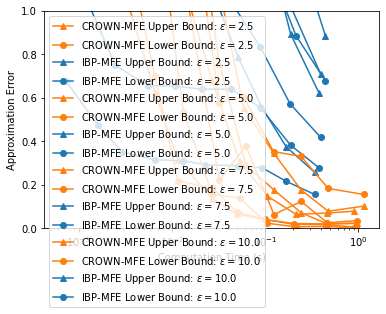

In [378]:
colors = ['r', 'g', 'b', 'c', 'm']

epsilons = results.keys()
epsilons = [2.5, 5.0, 7.5, 10.0]
fig, ax = plt.subplots()
for i, epsilon in enumerate(epsilons):
    crown_bounds = results[epsilon]['crown']
    ibp_bounds = results[epsilon]['ibp']
    u_min, u_max = results[epsilon]['exact']
    plot_comp_time_vs_approx_error(crown_bounds, ibp_bounds, u_min, u_max, ax=ax, show=False, color=colors[i], label=': $\epsilon='+str(epsilon)+'$', annotate=False)
ax.set_ylim(top=1)
plt.show()

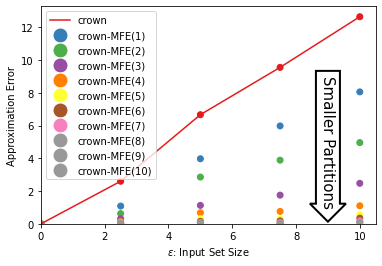

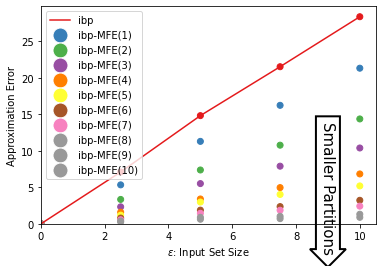

In [383]:
# CROWN error w.r.t. epsilon

cmap = plt.get_cmap('Set1')

for alg in ['crown', 'ibp']:

    epsilons = results.keys()
    fig, ax = plt.subplots()
    errors = np.empty((len(epsilons),3))
    for i, epsilon in enumerate(epsilons):
        bounds = results[epsilon][alg]
        u_min, u_max = results[epsilon]['exact']
        error_above = bounds[0,2]-u_max
        error_below = u_min-bounds[0,1]
        errors[i,:] = [epsilon, error_above, error_below]
        plt.scatter(np.ones_like(bounds[:,2])*epsilon, bounds[:,2]-u_max, color=[cmap(i) for i in range(len(bounds[:,2]))])

    plt.plot(errors[:,0], errors[:,1], c=cmap(0), label=alg)
    plt.xlabel('$\epsilon$: Input Set Size')
    # plt.ylabel('Approximation Error\n(of Upper Bound)',rotation=0,labelpad=50)
    plt.ylabel('Approximation Error')

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    legend_elements, labels = plt.gca().get_legend_handles_labels()
    for i in range(len(bounds[:,2])):
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='{}-MFE({})'.format(alg,i+1),
                              markerfacecolor=cmap(i+1), markersize=15))

    plt.legend(handles=legend_elements)
    plt.xlim(left=0)
    plt.ylim(bottom=0)

    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="None", ec="k", lw=2)
    t = ax.text(9, 5, "Smaller Partitions", ha="center", va="center", rotation=-90,
                size=15,
                bbox=bbox_props)

    plt.savefig('/Users/mfe/dnn_reachability_paper/figures/epsilon_vs_error_{}.png'.format(alg))
    plt.savefig('/Users/mfe/dnn_reachability_paper/figures/epsilon_vs_error_{}.pdf'.format(alg))

    plt.show()

In [767]:
reload(crown_ibp.bound_layers)

<module 'crown_ibp.bound_layers' from '/Users/mfe/code/reach_lp/crown_ibp/crown_ibp/bound_layers.py'>

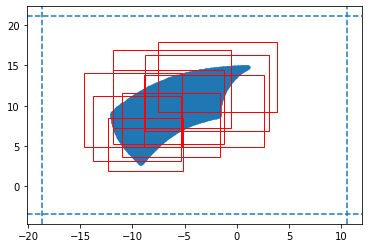

In [747]:
crown_ibp.bound_layers.xiang2017example()

CROWN...


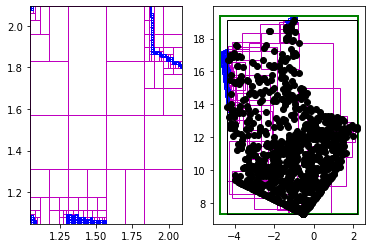

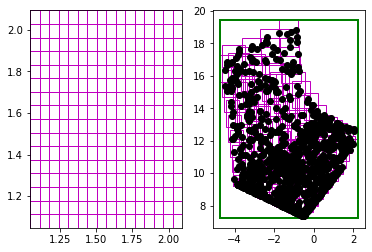

IBP...


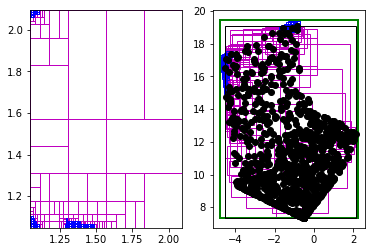

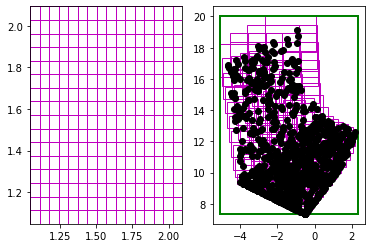

In [771]:
print("CROWN...")
xiang2020example(bound_method="crown")
print("IBP...")
xiang2020example(bound_method="ibp")

### Load Network weights from Xiang 2020

In [597]:
import scipy.io
mat = scipy.io.loadmat('/Users/mfe/Downloads/data_robot.mat')
np.set_printoptions(suppress=True, precision=5)

In [598]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Aug 23 14:14:56 2018',
 '__version__': '1.0',
 '__globals__': [],
 'network': array([[(array([[array([[-1.87, -0.03],
        [-0.84, -2.25],
        [-1.11, -0.6 ],
        [-0.85, -1.05],
        [ 0.07, -8.85]]),
         array([[ 2.04e+00, -1.87e+00,  1.43e+01, -4.47e+00, -1.33e-02],
        [ 3.19e+00,  1.11e+00, -5.24e+00,  8.52e+00,  2.77e-03]])]],
       dtype=object), array([[array([[ 3.58],
        [ 5.83],
        [ 2.09],
        [ 2.66],
        [13.51]]),
         array([[-0.52],
        [ 7.35]])]], dtype=object), array([[array(['tansig'], dtype='<U6'), array(['purelin'], dtype='<U7')]],
       dtype=object))]],
       dtype=[('weight', 'O'), ('bias', 'O'), ('activeType', 'O')])}

In [625]:
mat['network'][0][0][0][0][0]

array([[-1.87296, -0.02866],
       [-0.84023, -2.25227],
       [-1.10904, -0.6002 ],
       [-0.84835, -1.04995],
       [ 0.07309, -8.852  ]])

In [624]:
mat['network'][0][0][0][0][1]

array([[ 2.04445, -1.86677, 14.2524 , -4.47312, -0.01326],
       [ 3.18875,  1.1107 , -5.24184,  8.51545,  0.00277]])

In [627]:
mat['network'][0][0][1][0][0].squeeze()

array([ 3.58326,  5.82976,  2.09246,  2.65733, 13.50541])

In [626]:
mat['network'][0][0][1][0][1].squeeze()

array([-0.52256,  7.34787])